In [30]:
%matplotlib inline
import numpy as np
import pandas as pd
import graphviz
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels


data = pd.read_csv(r"../data/train.csv")
del data['Id']

X = data.loc[:, data.columns != 'Cover_Type'].values
Y = data['Cover_Type'].values

data.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [72]:
# utils
def k_fold(k, X, Y, total_classes=7):
    fold_per_class_size = (len(Y) // k) // total_classes
    class_sample_size = len(Y) // total_classes
    
    sort_idxs = Y.argsort()
    folds = [([], []) for _ in range(k)]
    for i in range(total_classes):
        class_idxs = np.random.permutation(sort_idxs[i * class_sample_size: (i + 1) * class_sample_size])
        for j in range(k - 1):
            folds[j][0].extend(X[class_idxs[j * fold_per_class_size: (j + 1) * fold_per_class_size]])
            folds[j][1].extend(Y[class_idxs[j * fold_per_class_size: (j + 1) * fold_per_class_size]])
        folds[k - 1][0].extend(X[class_idxs[(k - 1) * fold_per_class_size:]])
        folds[k - 1][1].extend(Y[class_idxs[(k - 1) * fold_per_class_size:]])
        
    return folds


def to_train_test(folds, test_fold_idx):
    test_x = np.array(folds[test_fold_idx][0])
    test_y = np.array(folds[test_fold_idx][1])
    train_x = np.concatenate([folds[i][0] for i in range(len(folds)) if i != test_fold_idx], axis=0)
    train_y = np.concatenate([folds[i][1] for i in range(len(folds)) if i != test_fold_idx], axis=0)
    return (train_x, train_y), (test_x, test_y)


def precision_recall(Y, Y_pred):
    classes, frequencies = np.unique(Y, return_counts=True)
    tp_fp_per_class = {c:[0, 0] for c in classes}
    for y, y_pred in zip(Y, Y_pred):
        if y == y_pred:
            # true positive
            tp_fp_per_class[y_pred][0] += 1
        else:
            # false positive
            tp_fp_per_class[y_pred][1] += 1
    return {c:[
                tp_fp_per_class[c][0] / sum(tp_fp_per_class[c]),
                tp_fp_per_class[c][0] / counter
            ] 
            for c, counter in zip(classes, frequencies)
           }

def plot_precision_recall(pr):
    fig, ax = plt.subplots()
    index = np.arange(len(pr))
    bar_width = 0.35
    opacity = 0.8

    rects1 = ax.bar(index, [v[0] for v in pr.values()], bar_width,
    alpha=opacity,
    color='b',
    label='Precision')

    rects2 = ax.bar(index + bar_width, [v[1] for v in pr.values()], bar_width,
    alpha=opacity,
    color='g',
    label='Recall')

    ax.set_xlabel('Class')
    ax.set_ylabel('Percent')
    ax.set_title('Precision Recall')
    ax.set_xticks(index + bar_width, [str(c) for c in pr])
    ax.legend()

    fig.tight_layout()
    return ax

from scikitplot.metrics import plot_confusion_matrix

[INFO] Fold #0
	Decision tree precision: 0.6931


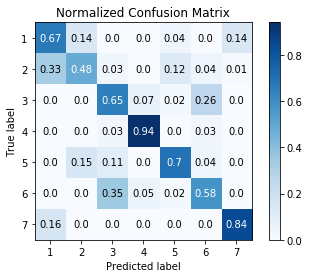

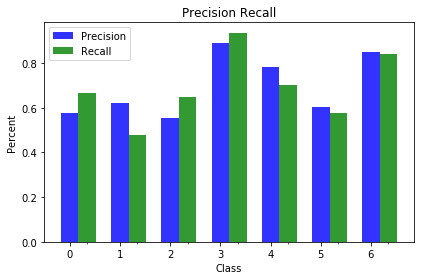

[INFO] Fold #1
	Decision tree precision: 0.6687


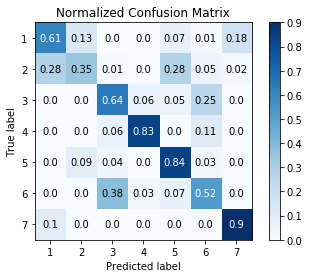

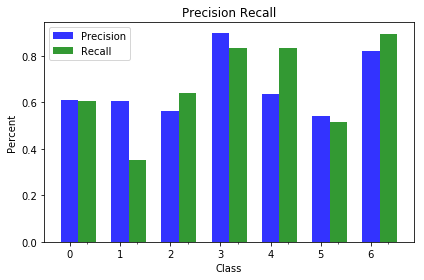

[INFO] Fold #2
	Decision tree precision: 0.6892


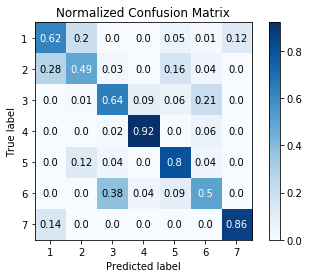

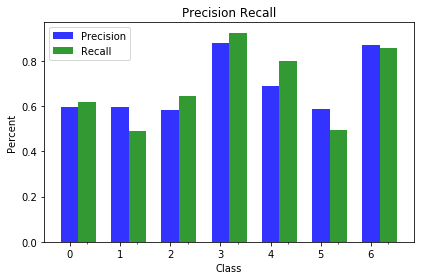

[INFO] Fold #3
	Decision tree precision: 0.6911


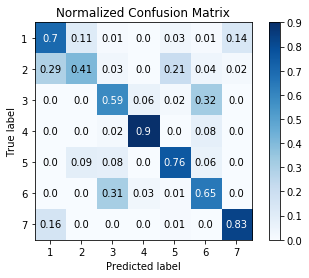

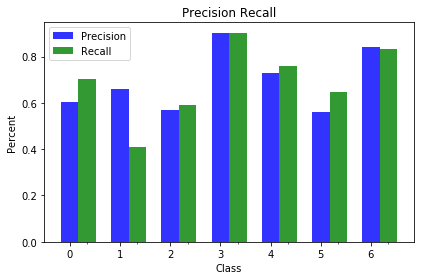

[INFO] Fold #4
	Decision tree precision: 0.6700


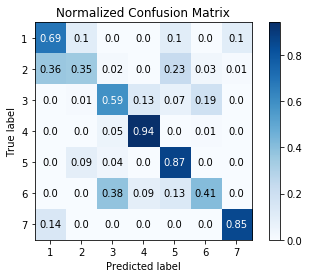

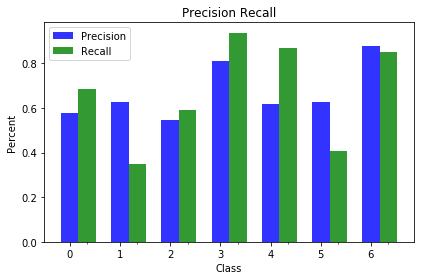

In [96]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
_X = X  # [:, 10:]
k = 5
folds = k_fold(k, _X, Y)

for i in range(k):
    print("[INFO] Fold #%d" % (i, ))
    (train_x, train_y), (test_x, test_y) = to_train_test(folds, i)
    
    dtree = DecisionTreeClassifier(criterion='entropy', min_impurity_decrease=0.005)
    dtree.fit(train_x, train_y)
    print("\tDecision tree precision: %.4f" % (dtree.score(test_x, test_y), ))
    test_y_pred = dtree.predict(test_x)

    plot_confusion_matrix(test_y, test_y_pred, normalize=True)
    plot_precision_recall(precision_recall(test_y, test_y_pred))
    plt.show()
        

In [97]:
from os import environ, pathsep
environ["PATH"] += pathsep + r'C:\Program Files (x86)\Graphviz2.38\bin'

dot_data = export_graphviz(dtree, out_file=None, filled=True, rounded=True, special_characters=True) 
graph = graphviz.Source(dot_data)

graph.render()

'Source.gv.pdf'

[INFO] Fold #0
	Naive Bayes accuracy 0.6005


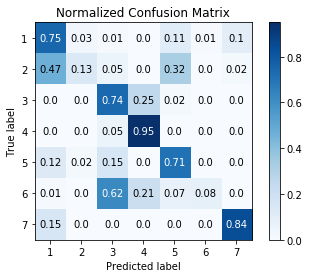

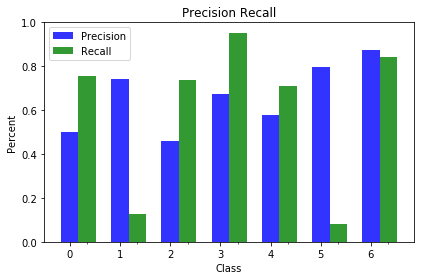

[INFO] Fold #1
	Naive Bayes accuracy 0.5979


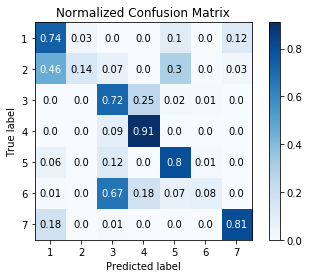

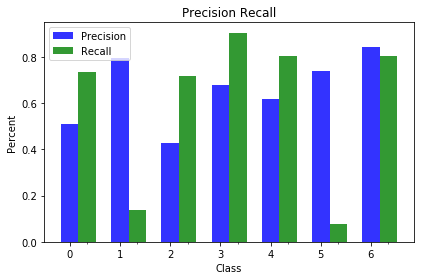

[INFO] Fold #2
	Naive Bayes accuracy 0.5880


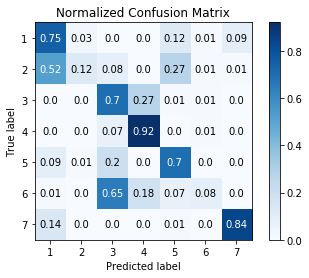

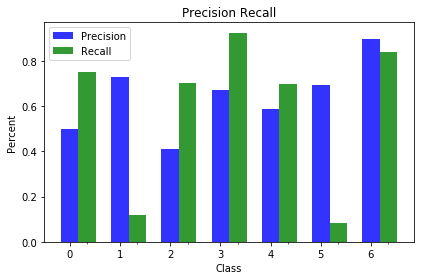

[INFO] Fold #3
	Naive Bayes accuracy 0.5853


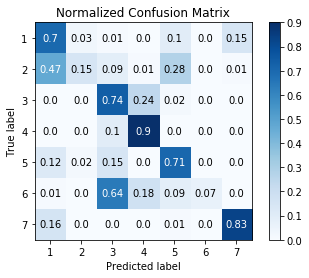

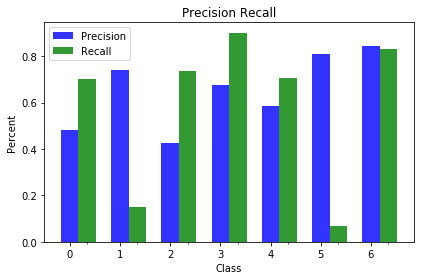

[INFO] Fold #4
	Naive Bayes accuracy 0.5916


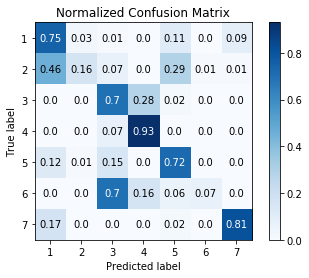

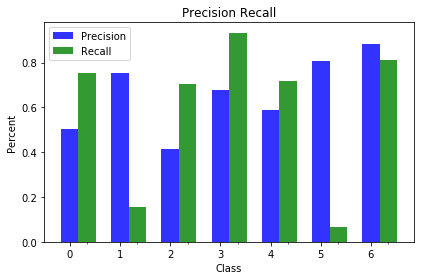

In [74]:
# naive bayes
from sklearn.naive_bayes import GaussianNB

_X = X[:, :]
k = 5
folds = k_fold(k, _X, Y)
# TODO pca 
for i in range(k):
    print("[INFO] Fold #%d" % (i, ))
    (train_x, train_y), (test_x, test_y) = to_train_test(folds, i)
    
    gnb = GaussianNB()
    gnb.fit(train_x, train_y)
    print("\tNaive Bayes accuracy %.4f" % (gnb.score(test_x, test_y), ))

    test_y_pred = gnb.predict(test_x)
    plot_confusion_matrix(test_y, test_y_pred, normalize=True)
    plot_precision_recall(precision_recall(test_y, test_y_pred))
    plt.show()


[INFO] Fold #0
	kNN accuracy: 0.7712


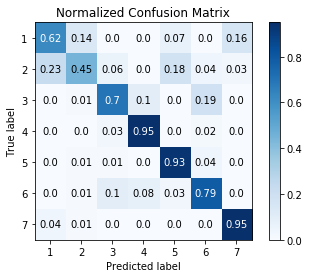

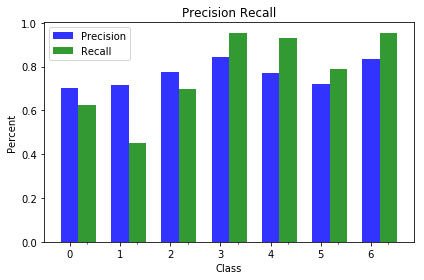

[INFO] Fold #1
	kNN accuracy: 0.7774


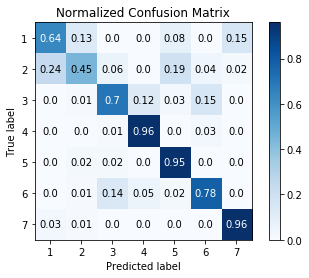

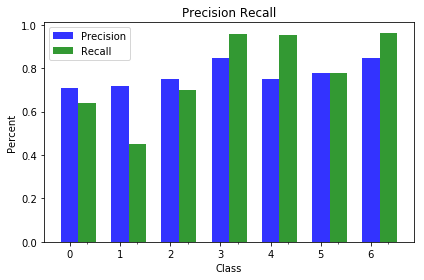

[INFO] Fold #2
	kNN accuracy: 0.7765


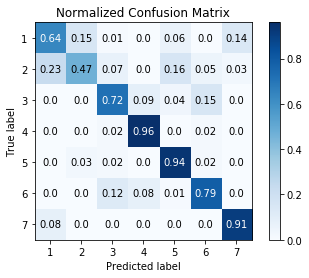

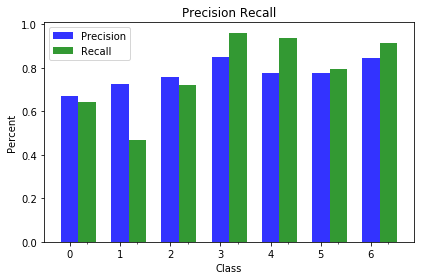

[INFO] Fold #3
	kNN accuracy: 0.7821


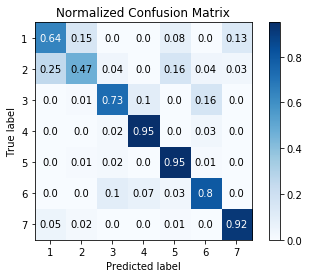

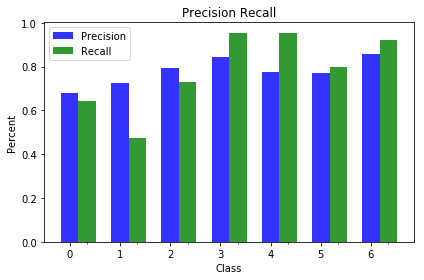

[INFO] Fold #4
	kNN accuracy: 0.7791


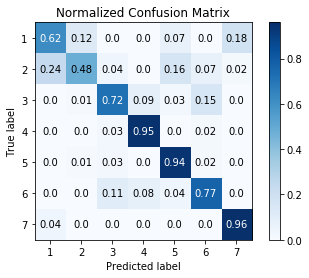

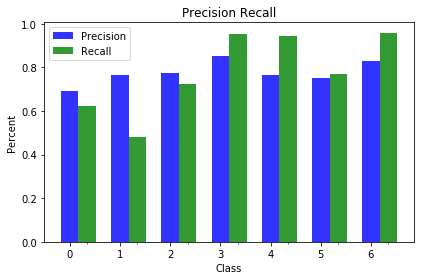

In [77]:
from sklearn.neighbors import KNeighborsClassifier

k = 5
folds = k_fold(k, X, Y)

# TODO optimizare neighb.
for i in range(k):
    print("[INFO] Fold #%d" % (i, ))
    (train_x, train_y), (test_x, test_y) = to_train_test(folds, i)

    nn = KNeighborsClassifier(n_neighbors=10)
    nn.fit(train_x, train_y)

    print("\tkNN accuracy: %.4f" % (nn.score(test_x, test_y)))
    test_y_pred = nn.predict(test_x)
    plot_confusion_matrix(test_y, test_y_pred, normalize=True)
    plot_precision_recall(precision_recall(test_y, test_y_pred))
    plt.show()

[INFO] Fold #0
Epoch 1/6
12096/12096 [==============================] - 2s 132us/step - loss: 1.1399 - acc: 0.5669
Epoch 2/6
12096/12096 [==============================] - 0s 33us/step - loss: 0.8011 - acc: 0.6743
Epoch 3/6
12096/12096 [==============================] - 0s 32us/step - loss: 0.7497 - acc: 0.6913
Epoch 4/6
12096/12096 [==============================] - 0s 32us/step - loss: 0.7150 - acc: 0.7102
Epoch 5/6
12096/12096 [==============================] - 0s 38us/step - loss: 0.6863 - acc: 0.7238
Epoch 6/6
3024/3024 [==============================] - 0s 131us/step
	Neural network accuracy: 0.7397


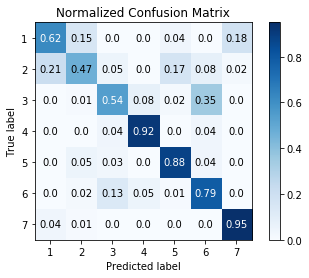

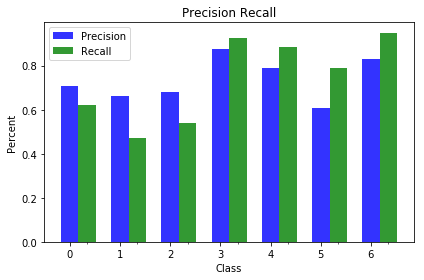

[INFO] Fold #1
Epoch 1/6
12096/12096 [==============================] - 2s 145us/step - loss: 1.0936 - acc: 0.5861
Epoch 2/6
12096/12096 [==============================] - 0s 31us/step - loss: 0.8026 - acc: 0.6753
Epoch 3/6
12096/12096 [==============================] - 0s 32us/step - loss: 0.7431 - acc: 0.6919
Epoch 4/6
12096/12096 [==============================] - 0s 35us/step - loss: 0.7137 - acc: 0.7032
Epoch 5/6
12096/12096 [==============================] - 0s 34us/step - loss: 0.6895 - acc: 0.7139
Epoch 6/6
3024/3024 [==============================] - 1s 172us/step
	Neural network accuracy: 0.7424


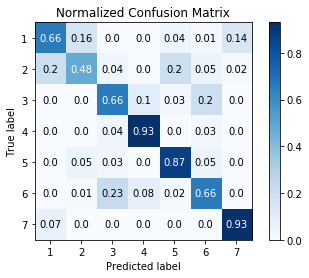

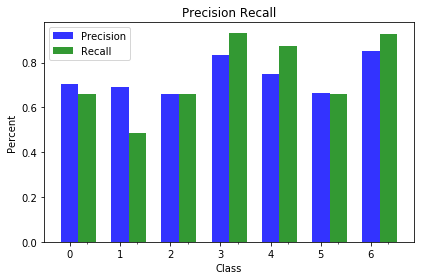

[INFO] Fold #2
Epoch 1/6
12096/12096 [==============================] - 2s 147us/step - loss: 1.0738 - acc: 0.5827
Epoch 2/6
12096/12096 [==============================] - 0s 39us/step - loss: 0.8022 - acc: 0.6750
Epoch 3/6
12096/12096 [==============================] - 0s 34us/step - loss: 0.7384 - acc: 0.6944
Epoch 4/6
12096/12096 [==============================] - 0s 36us/step - loss: 0.7112 - acc: 0.7109
Epoch 5/6
12096/12096 [==============================] - 0s 35us/step - loss: 0.6896 - acc: 0.7159
Epoch 6/6
3024/3024 [==============================] - 1s 168us/step
	Neural network accuracy: 0.7341


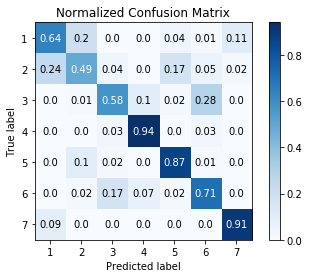

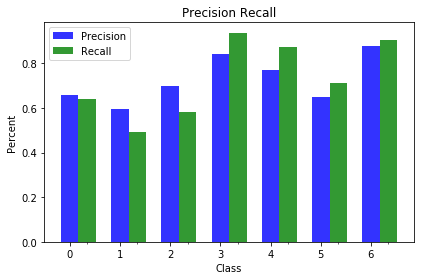

[INFO] Fold #3
Epoch 1/6
12096/12096 [==============================] - 2s 162us/step - loss: 1.1050 - acc: 0.5657
Epoch 2/6
12096/12096 [==============================] - 1s 42us/step - loss: 0.7959 - acc: 0.6757
Epoch 3/6
12096/12096 [==============================] - 0s 36us/step - loss: 0.7379 - acc: 0.6933
Epoch 4/6
12096/12096 [==============================] - ETA: 0s - loss: 0.7207 - acc: 0.706 - 0s 41us/step - loss: 0.7185 - acc: 0.7062
Epoch 5/6
12096/12096 [==============================] - 0s 37us/step - loss: 0.6855 - acc: 0.7209
Epoch 6/6
3024/3024 [==============================] - 1s 191us/step
	Neural network accuracy: 0.7454


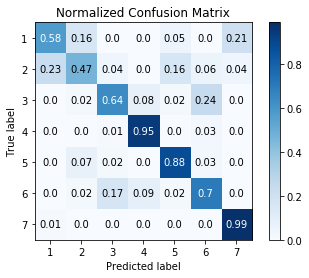

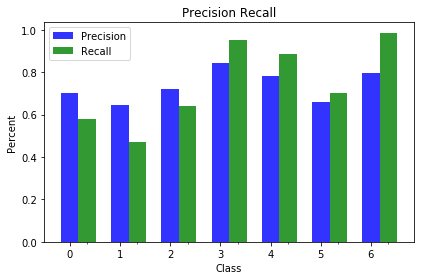

[INFO] Fold #4
Epoch 1/6
12096/12096 [==============================] - 2s 177us/step - loss: 1.0568 - acc: 0.5947
Epoch 2/6
12096/12096 [==============================] - 1s 46us/step - loss: 0.7985 - acc: 0.6796
Epoch 3/6
12096/12096 [==============================] - 0s 36us/step - loss: 0.7497 - acc: 0.6936
Epoch 4/6
12096/12096 [==============================] - 0s 39us/step - loss: 0.7195 - acc: 0.7044
Epoch 5/6
12096/12096 [==============================] - 1s 42us/step - loss: 0.6900 - acc: 0.7183
Epoch 6/6
3024/3024 [==============================] - 1s 200us/step
	Neural network accuracy: 0.7440


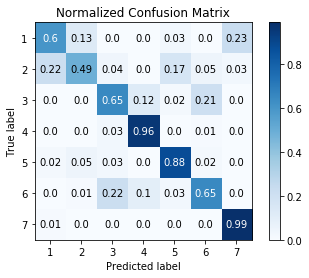

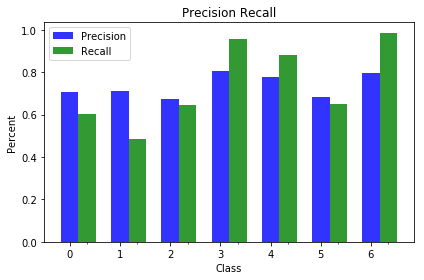

In [79]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, ReLU, ELU
from keras.utils import to_categorical
from sklearn.decomposition import PCA

# :10 approx 73 % accuracy on test set
# [0, 1, 2, 3, 4, 5, 9] approx 75 % accuracy on test set
# [0, 1, 2, 3, 5, 9] approx 73.5 % accuracy on test set
# [0, 1, 2, 3, 4, 5, 7, 9] approx 71 % accuracy on test set

pca = PCA(n_components=7)
_X = X[:, :10].astype(np.float64)
pca_components = pca.fit(_X).components_
# _X = _X.dot(pca_components.T)
_X = (_X - np.mean(_X, axis=0))
_X = _X / np.std(_X, axis=0)


np.random.seed(10);
k = 5
folds = k_fold(k, _X, Y)

# testing on test set -- not so good result; TODO see why?
# test_x = _X
# test_y = Y

# test_data = pd.read_csv(r"../data/test.csv")
# labels = {t[0]:t[1] for t in pd.read_csv(r"../data/sampleSubmission.csv").values}

# train_y = np.array([labels[_id] for _id in test_data['Id'].values], dtype=np.uint8)
# del test_data['Id']
# train_x = test_data.loc[:, :].values
# train_x = train_x[:, :10].astype(np.float64)
# train_x = train_x - np.mean(train_x, axis=0)
# test_x = test_x.dot(pca_components.T)

for i in range(k):
    print("[INFO] Fold #%d" % (i, ))
    (train_x, train_y), (test_x, test_y) = to_train_test(folds, i)
    classes = 7
    train_y = to_categorical(train_y - 1, classes)  # label in [1, 7] => -1
    test_y = to_categorical(test_y - 1, classes)  # label in [1, 7] => -1

    model = Sequential([
        Dense(units=128, input_shape=(train_x.shape[1], )),
        BatchNormalization(),
        ReLU(),
        Dense(units=96),
        BatchNormalization(),
        ReLU(),
        Dense(units=48),
        BatchNormalization(),
        ReLU(),
        Dense(units=7, activation="softmax"),
    ])

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    model.fit(train_x, train_y, epochs=6, batch_size=64)

    print("\tNeural network accuracy: %.4f" % (model.evaluate(test_x, test_y, batch_size=16)[1], ))
    test_y_pred = np.argmax(model.predict(test_x), axis=1) + 1
    test_y = np.argmax(test_y, axis=1) + 1
    plot_confusion_matrix(test_y, test_y_pred, normalize=True)
    plot_precision_recall(precision_recall(test_y, test_y_pred))
    plt.show()

[INFO] Fold #0
	SVM accuracy: 0.6518


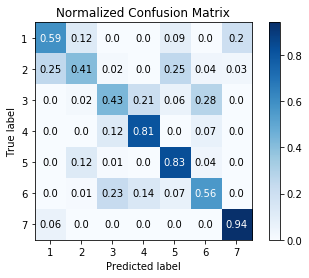

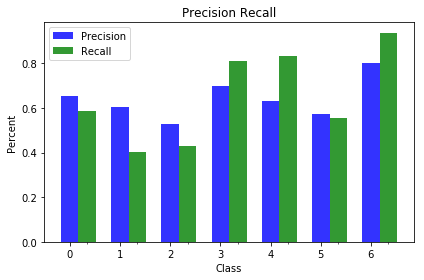

[INFO] Fold #1
	SVM accuracy: 0.6415


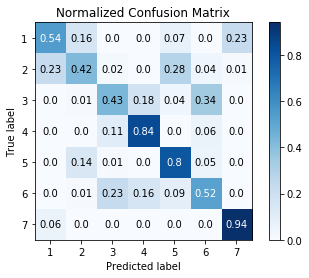

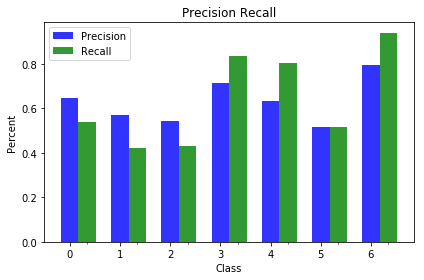

[INFO] Fold #2
	SVM accuracy: 0.6392


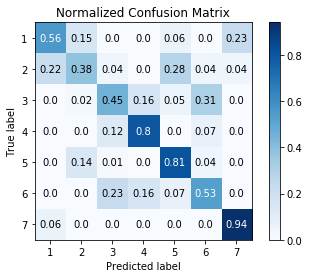

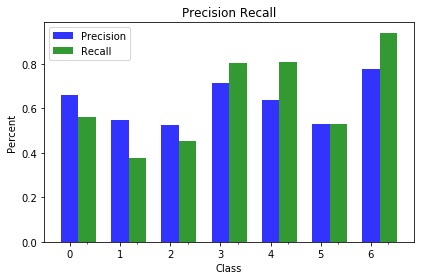

[INFO] Fold #3
	SVM accuracy: 0.6283


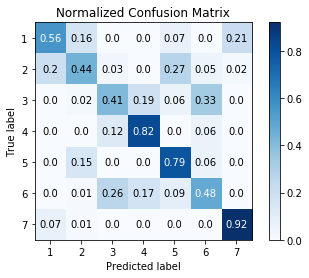

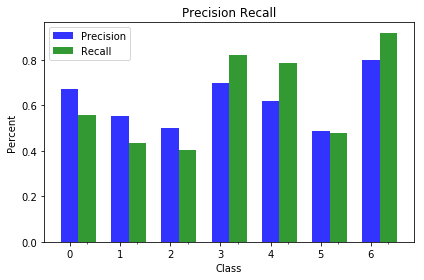

[INFO] Fold #4
	SVM accuracy: 0.6346


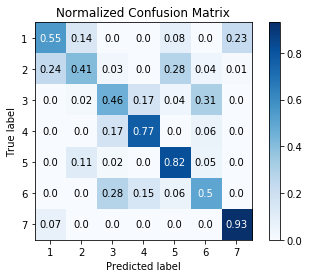

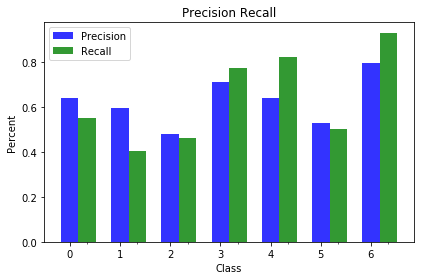

In [101]:
from sklearn.svm import SVC

k = 5
folds = k_fold(k, _X, Y)

for i in range(k):
    print("[INFO] Fold #%d" % (i, ))
    (train_x, train_y), (test_x, test_y) = to_train_test(folds, i)
    
    svm_classifier = SVC(gamma='scale', cache_size=2048)
    svm_classifier.fit(train_x, train_y)
    print("\tSVM accuracy: %.4f" % (svm_classifier.score(test_x, test_y)))
    
    test_y_pred = svm_classifier.predict(test_x)
    plot_confusion_matrix(test_y, test_y_pred, normalize=True)
    plot_precision_recall(precision_recall(test_y, test_y_pred))
    plt.show()

In [1]:
with open('xgboost_results.txt', 'r') as fin:
    for i in range(5):
        print("[INFO] Fold #%d" % (i, ))
        test_y = map(int, fin.readline().split(','))
        test_y_pred = map(int, fin.readline().split(','))
        plot_confusion_matrix(test_y, test_y_pred, normalize=True)
        plot_precision_recall(precision_recall(test_y, test_y_pred))
        plt.show()

[INFO] Fold #0


NameError: name 'plot_confusion_matrix' is not defined